In [6]:
# !pip install datasets

In [98]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json

from datasets import load_dataset

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.helpers import preprocessing as preproc
from src.helpers.postprocessing import from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [2]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.getenv("OUTPUTS_PATH")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [3]:
dataset = load_dataset("amazon_polarity")
FILES_PREFIX = "amazon_reviews"

# dataset = load_dataset("yelp_review_full")
# FILES_PREFIX = "yelp_reviews"

# dataset = load_dataset("imdb")
# FILES_PREFIX = "imdb_reviews"

# dataset = load_dataset("google_play_store_reviews")
# FILES_PREFIX = "google_play_store_reviews"

In [4]:
X_train = [f"{title} {text}" for title, text in zip(dataset['train']['title'], dataset['train']['content'])]
X_test = [f"{title} {text}" for title, text in zip(dataset['test']['title'], dataset['test']['content'])]

y_train = dataset['train']['label']
y_test = dataset['test']['label']

# X = X_train + X_test
# y = y_train + y_test

data = pd.DataFrame({ 'text': X_train, 'label': y_train })

In [5]:
N_SAMPLE = 5000

df_A = data[data['label'] == 1].sample(N_SAMPLE, random_state=RANDOM_STATE)
df_B = data[data['label'] == 0].sample(N_SAMPLE, random_state=RANDOM_STATE)
df = pd.concat([df_A, df_B], axis=0).reset_index(drop=True)

In [37]:
df

,text,label,embedding,sentiment_finbert,sentiment_score_finbert,sentiment_distilbert,sentiment_score_distilbert
0,Perfect Mantra I've been looking for this mant...,1,"[0.007807049434632063, 0.030451875180006027, -...","{'neutral': 0.8560859560966492, 'positive': 0....",0.115722,"{'positive': 0.9212492108345032, 'neutral': 0....",0.882025
1,Quality I'm just a little disapointed with the...,1,"[0.039840616285800934, 0.024724069982767105, -...","{'neutral': 0.6148350834846497, 'negative': 0....",-0.294519,"{'negative': 0.6277590095996857, 'neutral': 0....",-0.508282
2,Exceptional murder-mystery writer scores big. ...,1,"[0.0034261085093021393, 0.015346183441579342, ...","{'neutral': 0.8212524652481079, 'positive': 0....",0.147671,"{'positive': 0.8934776484966278, 'neutral': 0....",0.853715
3,all the prodding questions you never wanted to...,1,"[-0.0014260949101299047, 0.02775280550122261, ...","{'neutral': 0.8815059661865234, 'negative': 0....",-0.038792,"{'positive': 0.8816157430410385, 'neutral': 0....",0.831368
4,Best Wok ever I am so glad I bought this wok. ...,1,"[-0.006502537056803703, -0.06767161935567856, ...","{'neutral': 0.9088772535324097, 'positive': 0....",0.025279,"{'positive': 0.9359345585107803, 'negative': 0...",0.891844
...,...,...,...,...,...,...,...
9995,Doesn't work for me While I applaud the focus ...,0,"[0.01933443546295166, 0.04884188994765282, 0.0...","{'negative': 0.5224195122718811, 'neutral': 0....",-0.493055,"{'negative': 0.665358766913414, 'neutral': 0.2...",-0.605424
9996,Beyond Stupid One wonders about all the people...,0,"[-0.020204896107316017, 0.048844318836927414, ...","{'negative': 0.6272358894348145, 'neutral': 0....",-0.594662,"{'positive': 0.8940904587507248, 'neutral': 0....",0.833796
9997,Buyer Be Very Wary The trusted leader in child...,0,"[0.021161140874028206, -0.016750086098909378, ...","{'neutral': 0.5817084312438965, 'negative': 0....",-0.351420,"{'negative': 0.7447640299797058, 'neutral': 0....",-0.657378
9998,I'll bring earplugs to the state fair DATE... ...,0,"[0.003520581405609846, 0.00879414938390255, -0...","{'neutral': 0.9065130352973938, 'positive': 0....",0.026392,"{'positive': 0.5391621738672256, 'neutral': 0....",0.365100


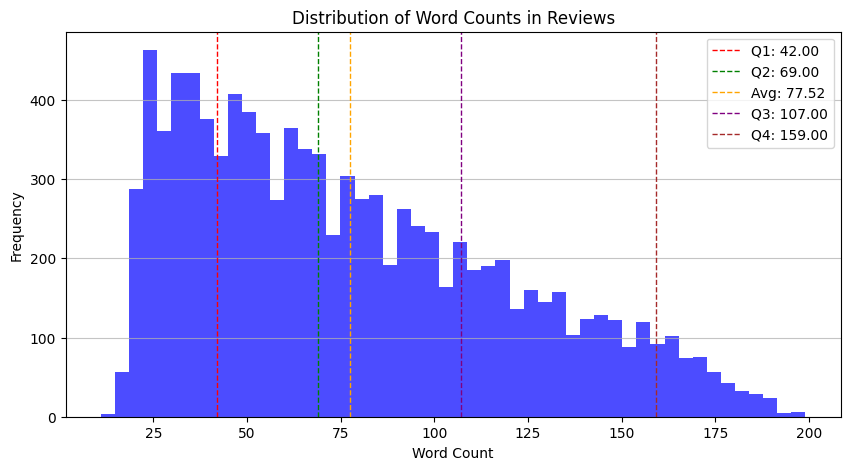

In [ ]:
word_counts = df["text"].apply(lambda x: len(x.split()))
q1_word_counts = word_counts.quantile(0.25)
q2_word_counts = word_counts.quantile(0.50)
avg_word_counts = word_counts.mean()
q3_word_counts = word_counts.quantile(0.75)
q4_word_counts = word_counts.quantile(0.95)
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(q1_word_counts, color='red', linestyle='dashed', linewidth=1, label=f'Q1: {q1_word_counts:.2f}')
plt.axvline(q2_word_counts, color='green', linestyle='dashed', linewidth=1, label=f'Q2: {q2_word_counts:.2f}')
plt.axvline(avg_word_counts, color='orange', linestyle='dashed', linewidth=1, label=f'Avg: {avg_word_counts:.2f}')
plt.axvline(q3_word_counts, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_word_counts:.2f}')
plt.axvline(q4_word_counts, color='brown', linestyle='dashed', linewidth=1, label=f'Q4: {q4_word_counts:.2f}')
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Pre-processing data

##### 1. Data cleaning

In [7]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/amazon_reviews_texts.pickle
Loaded 10000 texts


##### 2. Embedding texts

In [8]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/amazon_reviews_embeddings.pickle
Loaded 10000 embeddings


##### 3.a. Sentiment Analysis: FinBERT

In [9]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_finbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_finbert"] = sentiments
df["sentiment_score_finbert"] = df["sentiment_finbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_sentiments_finbert.pickle
Loaded 10000 sentiments


##### 3.b. Sentiment Analysis: Multilingual DistilBERT

In [10]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_distilbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_distilbert"] = sentiments
df["sentiment_score_distilbert"] = df["sentiment_distilbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_sentiments_distilbert.pickle
Loaded 10000 sentiments


# TOPOL Modeling

### Prepare data

In [11]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

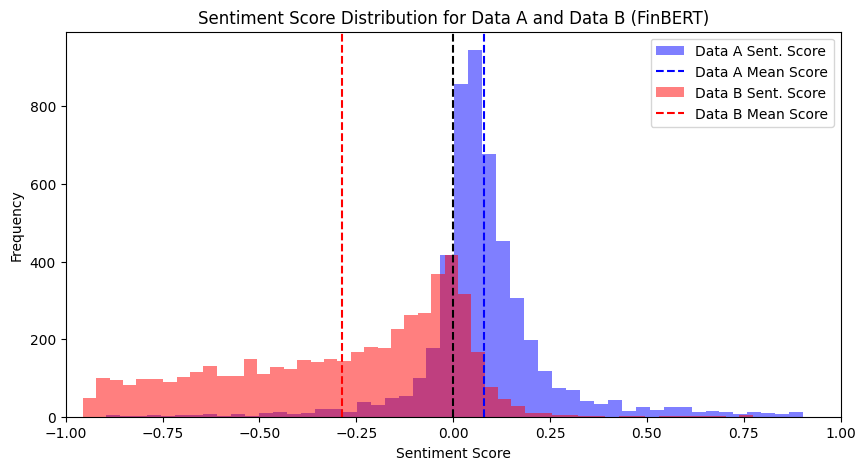

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_finbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_finbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (FinBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_finbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

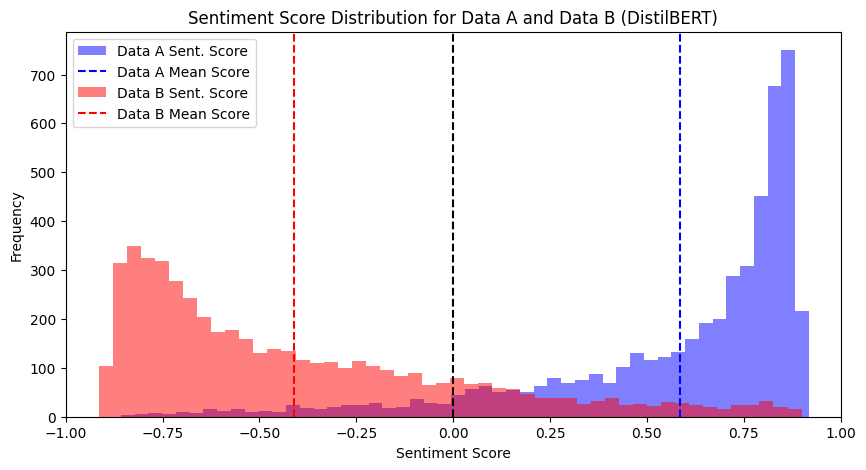

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_distilbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_distilbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (DistilBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_distilbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [14]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=True,
)

### TOPOL modeling analysis

In [15]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied successfully.
Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [16]:
topol_model.dataset_A.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,884,"{'album': 661, 'cd': 619, 'date': 470, 'num': ...","[0.010969975832860277, -0.00956266723154865, -...","[-2.2228566312412332, 10.503755383362058]",[One of the best albums of DATE Set aside copy...,"{'cd': 0.41533197940001637, 'love': 0.16344568..."
1,1,660,"{'movie': 649, 'great': 322, 'date': 312, 'fil...","[0.0020336493143214753, 0.0272367533461103, -0...","[-1.0633949152447961, 6.898931062582768]",[Great Movie This is possibly one of the best ...,"{'date': 0.33194996434119656, 'movie': 0.31350..."
2,2,1056,"{'book': 1598, 'read': 794, 'date': 405, 'stor...","[0.009626297939414117, 0.022107493239962587, -...","[-2.0248910303255827, 4.598665111895763]","[A MOST PLEASANT READ What a pleasure, in DATE...","{'book': 0.3719685553913424, 'read': 0.2789764..."
3,3,350,"{'num': 265, 'great': 216, 'good': 143, 'date'...","[-0.003598655094860338, -0.010274555067787463,...","[5.474862151145935, 7.339230632781982]",[Almost perfect I absolutely love this product...,"{'product': 0.2462034597621263, 'num': 0.24620..."
4,4,119,"{'book': 198, 'read': 64, 'good': 44, 'num': 4...","[0.00632185865158265, 0.033157376474661736, -0...","[-2.6708371008143708, 4.236718937128532]",[Sad to see all of these one-star ratings I th...,"{'book': 0.4738220342035632, 'read': 0.1930386..."
5,5,428,"{'date': 231, 'num': 223, 'great': 196, 'good'...","[0.015259063576739328, 0.0012670419295505424, ...","[4.177431689557906, 5.727501892597876]",[good value My daughter DATE (then six) got th...,"{'date': 0.3349302636111386, 'love': 0.2215213..."
6,6,451,"{'book': 855, 'great': 186, 'good': 179, 'date...","[-0.0030579739797956147, 0.015465030595007149,...","[-1.1677268584921725, 3.388652473225562]",[Cool ! Easy to read and best of all - it all ...,"{'book': 0.5860261297231085, 'great': 0.274546..."
7,7,385,"{'num': 244, 'great': 215, 'date': 144, 'use':...","[-0.002413772076633668, -0.0019040538731723564...","[5.7089480938075425, 5.868081342399894]",[nothing like a quality utensil! I works as ad...,"{'like': 0.14862039858266382, 'good': 0.148620..."
8,8,146,"{'date': 89, 'product': 79, 'great': 78, 'num'...","[0.0024471942984023807, -0.005852374096707224,...","[5.141695660823631, 5.023153816183952]",[Great Hair! I have been using this shampoo fo...,"{'date': 0.23608359068838206, 'hair': 0.214621..."
9,9,85,"{'num': 105, 'camera': 63, 'great': 55, 'use':...","[0.0034408766639364118, -0.0037713752912275273...","[4.486818421588224, 7.455143833160401]",[User friendly and great results I have been i...,"{'camera': 0.37867848255685405, 'great': 0.269..."


In [27]:
topol_model.dataset_B.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,510,"{'cd': 310, 'album': 293, 'like': 272, 'music'...","[0.0043278797369709415, 0.006608367727305592, ...","[-1.480399962383158, 10.461545989560147]",[NUM well crafted songs does NOT make a great ...,"{'cd': 0.29479114175178583, 'songs': 0.2254285..."
1,1,528,"{'movie': 771, 'film': 266, 'time': 222, 'like...","[-0.011750044492504403, 0.04628942530116271, -...","[-1.6337700097003218, 7.4951941045847805]",[I Can't Believe I Watched the Whole Thing Def...,"{'movie': 0.4341706877418103, 'time': 0.200386..."
2,2,64,"{'book': 77, 'date': 31, 'read': 30, 'num': 19...","[0.004736882327051717, 0.030183602939359844, -...","[-2.35247384570539, 4.404407557100058]",[Professional Editing makes ALL the difference...,"{'date': 0.2160228448231658, 'book': 0.1571075..."
3,3,707,"{'num': 575, 'date': 550, 'time': 302, 'produc...","[-0.01536258327481154, 0.010070693165926188, -...","[5.473533558668477, 7.259392639197926]",[Worthless - Do NOT buy I read the other revie...,"{'date': 0.24714061059936682, 'product': 0.205..."
4,4,922,"{'book': 1527, 'read': 573, 'just': 336, 'like...","[0.002047070511000441, 0.04006326685275524, -0...","[-2.967761978296939, 3.96417471359195]",[Couldn't even finish it I couldn't get past p...,"{'book': 0.4448866660896023, 'read': 0.2607956..."
5,5,565,"{'num': 425, 'date': 275, 'product': 171, 'tim...","[0.0008793312056720014, 0.015555453612833578, ...","[4.437671084952566, 5.9537278263969755]",[wasted my money completely This SOUNDED like ...,"{'date': 0.2959936247682196, 'num': 0.20491866..."
6,6,493,"{'book': 965, 'num': 258, 'information': 138, ...","[-0.009222774204930308, 0.0248857992228369, -0...","[-1.3132190037571634, 3.041649305796285]",[Does not deliver what it promises I was disco...,"{'book': 0.6723928473299418, 'waste': 0.107389..."
7,7,367,"{'num': 206, 'date': 205, 'time': 117, 'use': ...","[-0.01814533203043925, 0.02230644906489261, -0...","[5.793541704114191, 5.971608039793591]",[An adjustable disappointment When I first got...,"{'water': 0.22501116876899405, 'date': 0.22013..."
8,8,156,"{'product': 98, 'date': 73, 'like': 63, 'just'...","[-0.01214948244943606, 0.006715209303365555, -...","[5.362081118119069, 5.1912007209582205]",[Not as advertised and reviewed After searchin...,"{'product': 0.39872264672473745, 'hair': 0.239..."
9,9,178,"{'num': 168, 'date': 139, 'camera': 81, 'softw...","[-0.01885563063899937, 0.01092191354992598, -0...","[4.70054795567909, 7.860433709755372]","[DOES NOT WORK I purchased this product, tried...","{'num': 0.2843369262762915, 'product': 0.22447..."


Drift computed successfully, ready to vizualize.


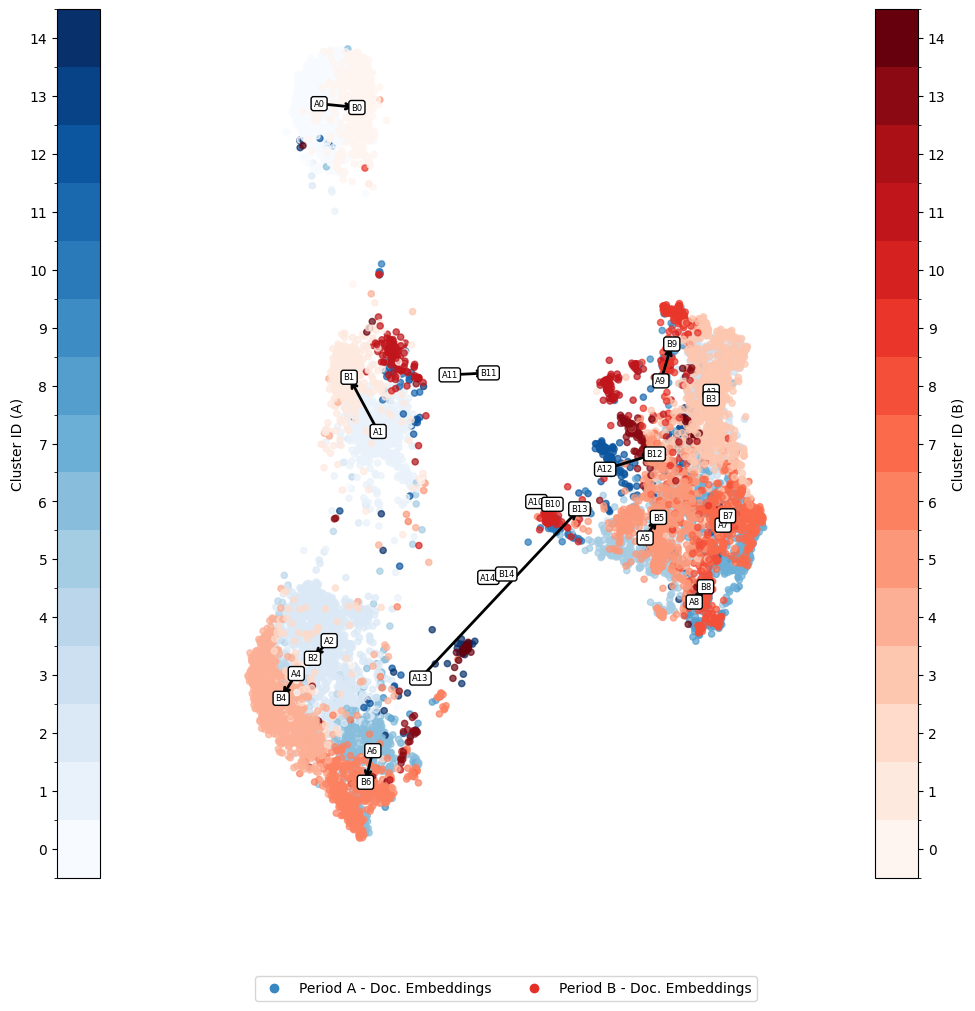

In [18]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [19]:
no_nan_drifts = { k: v for k, v in topol_model.drifts.items() if isinstance(v, np.ndarray) }
drifts_df = pd.DataFrame.from_dict(no_nan_drifts, orient='index', columns=['x', 'y'])
drifts_df.index.name = "Cluster"

In [105]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

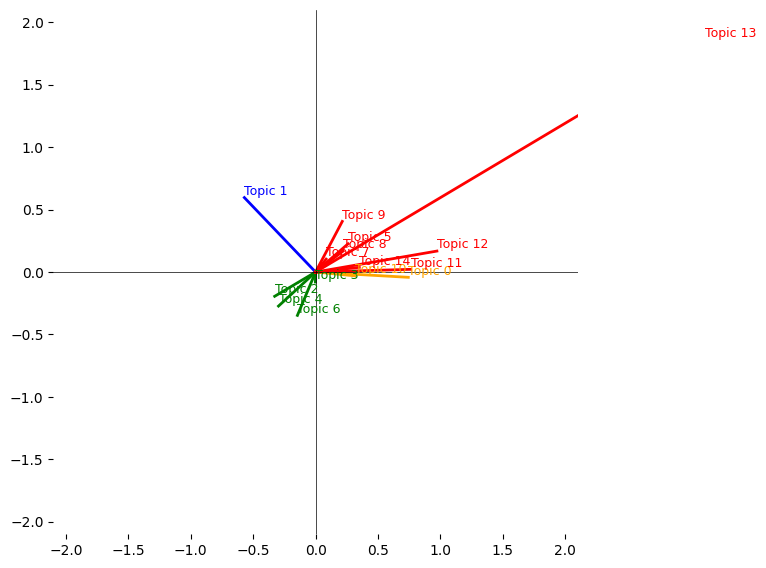

In [106]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [22]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

Loaded 123 narrative dimensions from /Users/tig1/Programming/TOPOL/data/narrative_dimensions.pickle


In [23]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [24]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [25]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [26]:
zipped_representative_docs = list(zip(
    topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
    topol_model.dataset_B.cluster_info['Top_Representative_Docs']
))
top_n_docs = 3  # Number of top documents to compare per cluster

for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

    # Get the representative documents for each cluster
    if top_n_docs is not None:
        text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
        text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
    else:
        text1 = from_list_to_string(top_docs_A)
        text2 = from_list_to_string(top_docs_B)

    # Generate the prompt for the LLM
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, max_tokens=1000000)

    # Dynamic response variable (you can also use a list or dict instead of naming each one)
    var_name = f"response_row{i}"
    globals()[var_name] = response

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

    print(f"✅ Processed and saved row {i}")

  0%|          | 0/15 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Enthusiasm for the Album",
    "polar_extremes_subtitle": "Disappointment – Enthusiasm",
    "presence": "both",
    "coverage_text1": 70,
    "coverage_text2": 70,
    "difference_confidence": 90,
    "cosine_similarity": -0.85,
    "text1_evidence_sentences": [
      "This is one of those rare albums that each and every single song on there is absolutely amazing.",
      "The kind of CD you put in car and enjoy the ride, because each song makes you move and sing along.",
      "This is a brilliant album, and a brilliant artist."
    ],
    "text2_evidence_sentences": [
      "But this release is just not that good.",
      "What a waste of hard earned cash!!! this CD was such bore with what seemed to be a complete lack of imagination.",
      "I am selling my copy of this album without even ripping it because there isn't a single song on it that does anything new with the music or is in any way better than the originals. In short, they 